In [100]:
import numpy as np
from scipy.stats.mstats import mode
from copy import deepcopy
import pandas as pd
import time
%matplotlib inline

In [2]:
train_np = np.loadtxt('data/train.txt', delimiter=',', skiprows=1)
train_np.shape

(43200, 57)

In [3]:
# Most frequent values for each sensor
mode(train).mode.data

NameError: name 'train' is not defined

In [83]:
df_train = pd.read_csv('data/train.txt', skipinitialspace=True)
df_test = pd.read_csv('data/test.txt', skipinitialspace=True)
df_train.rename(columns={'Timestamp (DHHMM)':'time'}, inplace=True)
df_test.keys()

Index([u'Sensor ID', u'Start Time', u'End Time', u'People Count'], dtype='object')

In [135]:
# #### To build a submission file
df_train_current = df_train_neighbors_avg
submission_name = 'nearest_v4.csv'

def timestamptoindex(ts):
    mm = ts % 100
    hh = (ts % (100 * 100)) // 100
    d = ts // (100 * 100)
    
    index = mm + 60 * hh + 60 * 24 * (d - 1)
    return index

def get_count(row, train):
    start = int(row['Start Time'])
    end = int(row['End Time'])
    col = row['Sensor ID']
    i0 = timestamptoindex(start)
    i1 = timestamptoindex(end)
    
    cum_sum = train[col][i0:i1].sum()
    return cum_sum

df_test['Count'] = df_test.apply(lambda row: get_count(row, df_train_current),axis=1)

# Saving it under the name submission_name
df_test['Index'] = df_test.index + 1
df_test[['Index', 'Count']].to_csv(submission_name, index=False)

In [134]:
df_test.head()

,Sensor ID,Start Time,End Time,People Count
0,S9,11100,11159,-59
1,S26,11100,11159,-59
2,S48,11100,11159,-59
3,S9,11200,11259,-59
4,S26,11200,11259,-59


In [72]:
test[['Index', 'Count']].to_csv('dummy.csv', index=False)

In [8]:
df_train.head()

,time,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S47,S48,S49,S50,S51,S52,S53,S54,S55,S56
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


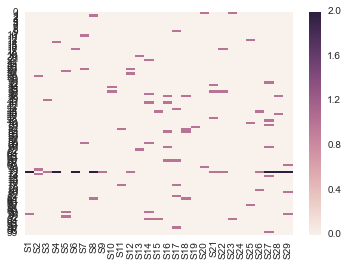

In [53]:
import seaborn as sns
df = df_train[['S'+str(i) for i in xrange(1, 30)]][:100]

sns.heatmap(df)

In [54]:
# Nearest neighbors model
adjacency_list = {
    1: [2, 4, 35],
    2: [1, 34, 35, 36, 41],
    3: [4, 8],
    4: [1, 3],
    5: [7, 45],
    6: [8, 12],
    7: [5, 55],
    8: [3, 6],
    9: [12, 44],
    10: [11, 55],
    11: [10, 13],
    12: [6, 9],
    13: [11, 39],
    14: [16, 54],
    15: [14, 16],
    16: [14, 15, 17],
    17: [16, 56],
    18: [19, 56],
    19: [18, 20],
    20: [19, 21],
    21: [20, 22, 23],
    22: [21, 23, 43],
    23: [21, 24],
    24: [23, 25],
    25: [24, 26],
    26: [25, 27],
    27: [26, 28, 29],
    28: [27, 47],
    29: [27, 30],
    30: [29, 31],
    31: [30, 32],
    32: [31, 33],
    33: [32, 34, 35],
    34: [2, 33, 35, 36, 41],
    35: [1, 2, 34, 36, 41],
    36: [2, 34, 35, 41],
    37: [36, 38],
    38: [37, 40],
    39: [13, 43],
    40: [38],
    41: [2, 36, 42],
    42: [41, 46],
    43: [22, 39],
    44: [9, 45],
    45: [5, 44],
    46: [42],
    47: [28, 48],
    48: [47, 49],
    49: [48, 50],
    50: [49, 51],
    51: [50, 52, 53],
    52: [50, 51, 53],
    53: [51, 52, 54],
    54: [53, 14],
    55: [7, 10],
    56: [17, 18]
}

In [133]:
# Several possibilities to average the result among the neighbors:
#    - cumulative sum of neighbors (v1)
#    - average (truncated) (v2)
#    - average (raw) (v3)
#    - average (rounded) (v4)
def fill_neighbors(row, col_name, adjacency_list):
    if row[col_name] == -1:
        new_value = 0.
        count = 0
        col_ind = int(col_name[1:])
        for n in adjacency_list[col_ind]:
            if row[n] != -1:
                new_value += row[n]
                count += 1
        if count:
            return round(new_value / (1. * count))
        return new_value
    else:
        return row[col_name]



In [125]:
col_names = ['S'+str(i) for i in xrange(1, 57)]
df_train_neighbors_avg = df_train.copy()

In [134]:
for col_name in col_names:
    start = time.time()
    df_train_neighbors_avg[col_name] = df_train.apply(lambda row: fill_neighbors(row, col_name, adjacency_list),axis=1)
    total_time = time.time() - start
    print 'Col {} computed in {}'.format(col_name, total_time)

Col S1 computed in 2.10306501389
Col S2 computed in 2.03278207779
Col S3 computed in 2.06884407997
Col S4 computed in 2.40533804893
Col S5 computed in 2.20628619194
Col S6 computed in 2.76762294769
Col S7 computed in 2.09706306458
Col S8 computed in 2.02352499962
Col S9 computed in 2.57313513756
Col S10 computed in 2.03930902481
Col S11 computed in 2.00582504272
Col S12 computed in 2.09261488914
Col S13 computed in 2.63840794563
Col S14 computed in 2.64893007278
Col S15 computed in 2.12684106827
Col S16 computed in 1.99684691429
Col S17 computed in 2.40207600594
Col S18 computed in 2.01254200935
Col S19 computed in 2.02449917793
Col S20 computed in 2.66367197037
Col S21 computed in 1.98050689697
Col S22 computed in 2.03429889679
Col S23 computed in 2.53910899162
Col S24 computed in 1.97597718239
Col S25 computed in 1.96993112564
Col S26 computed in 2.46613812447
Col S27 computed in 1.95004200935
Col S28 computed in 2.49723696709
Col S29 computed in 2.96787405014
Col S30 computed in 2.4

In [127]:
# Checking that all the values are filled
cum_sum = 0
for col in col_names:
    cum_sum += len(df_train_neighbors_avg[df_train_neighbors[col] == -1])
print cum_sum

0


In [116]:
df_train_neighbors.head()

,time,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S47,S48,S49,S50,S51,S52,S53,S54,S55,S56
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
round(3./5)

1.0